# Metadata and Text concatenated network

## Imports

In [234]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import string
import re
import emoji
import random
import keras
import time
import warnings

warnings.filterwarnings('ignore')

import sys
sys.path.append("../") # make it possible to import functions from different files that are in folders a level up

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin' # used for displaying the model plot

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report

from keras.models import Model
from keras.layers import Dense, Dropout, Concatenate
from data.functions.string_tools import print_split_shapes
from keras.callbacks import History

from tensorflow.keras.utils import plot_model
from transformers import AutoTokenizer
from text.tools.bert_model import get_model, MAX_LEN

# SEEDS
random_state = 111

os.environ['PYTHONHASHSEED'] = str(random_state)
random.seed(random_state)
np.random.seed(random_state)
tf.random.set_seed(random_state)

epochs = 8
batch_size= 128
txt_size= 16

## Check if a GPU is available

In [235]:
if tf.test.gpu_device_name():
  print('GPU found')
else:
  print("No GPU found")

GPU found


## Load the data in

In [236]:
folder_path = '../data/selected_data/all_data_selected.csv'

df = pd.read_csv(folder_path)

df.drop('Unnamed: 0', axis=1, inplace=True)

df.head()

,full_text,retweet_count,user_description,user_followers_count,user_friends_count,user_favourites_count,user_statuses_count,user_media_count,hashtags_count,username,...,part_of_thread,tweet_sentiment,user_creation_tweet_diff,tweeted_in_daypart_day,tweeted_in_daypart_evening,tweeted_in_daypart_morning,tweeted_in_daypart_night,user_created_in_daypart_day,user_created_in_daypart_evening,real_fake_grade
0,Our daily update is published. States reported...,171,We try to provide the most comprehensive state...,468030,13,85,2594,1364,0,The COVID Tracking Project,...,0,0,16384932,0,1,0,0,0,0,1.0
1,President Trump Asked What He Would Do If He W...,0,"Spoof news, political satire, parody and more!...",803,97,1,57502,3,2,The Spoof,...,0,0,293776787,1,0,0,0,0,0,-1.0
2,States reported 630 deaths. We are still seein...,71,We try to provide the most comprehensive state...,468030,13,85,2594,1364,0,The COVID Tracking Project,...,1,0,9039963,0,1,0,0,0,0,1.0
3,Low #vitaminD was an independent predictor of ...,40,Medscape provides breaking medical news and ex...,215969,39457,2206,49892,16563,1,Medscape,...,0,1,375950159,0,0,0,1,0,1,1.0
4,A common question: why are the cumulative outc...,0,We try to provide the most comprehensive state...,468030,13,85,2594,1364,1,The COVID Tracking Project,...,1,2,2470004,0,1,0,0,0,0,1.0


## Prepare the data

### Drop duplicated and not set fields

In [237]:
df['user_description'] = df['user_description'].apply(lambda x: x if pd.notna(x) else '')
print(df.shape)
df = df.dropna(subset=['full_text']).drop_duplicates(subset=['full_text'])
df.shape

(7905, 44)


(7816, 44)

### Combine text fields

In [238]:
df['text'] = df['full_text']
df['user_info'] = df['username'] + ' ' + df['user_description']

df.drop(['username', 'user_description'], axis=1, inplace=True)

df.head()

,full_text,retweet_count,user_followers_count,user_friends_count,user_favourites_count,user_statuses_count,user_media_count,hashtags_count,has_user_url,text_length,...,user_creation_tweet_diff,tweeted_in_daypart_day,tweeted_in_daypart_evening,tweeted_in_daypart_morning,tweeted_in_daypart_night,user_created_in_daypart_day,user_created_in_daypart_evening,real_fake_grade,text,user_info
0,Our daily update is published. States reported...,171,468030,13,85,2594,1364,0,1,163,...,16384932,0,1,0,0,0,0,1.0,Our daily update is published. States reported...,The COVID Tracking Project We try to provide t...
1,President Trump Asked What He Would Do If He W...,0,803,97,1,57502,3,2,1,125,...,293776787,1,0,0,0,0,0,-1.0,President Trump Asked What He Would Do If He W...,"The Spoof Spoof news, political satire, parody..."
2,States reported 630 deaths. We are still seein...,71,468030,13,85,2594,1364,0,1,245,...,9039963,0,1,0,0,0,0,1.0,States reported 630 deaths. We are still seein...,The COVID Tracking Project We try to provide t...
3,Low #vitaminD was an independent predictor of ...,40,215969,39457,2206,49892,16563,1,1,112,...,375950159,0,0,0,1,0,1,1.0,Low #vitaminD was an independent predictor of ...,Medscape Medscape provides breaking medical ne...
4,A common question: why are the cumulative outc...,0,468030,13,85,2594,1364,1,1,277,...,2470004,0,1,0,0,0,0,1.0,A common question: why are the cumulative outc...,The COVID Tracking Project We try to provide t...


In [239]:
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [240]:
def clean_text(text):
    text = text.lower()

    # vervang alle urls
    text = re.sub('https?://\S+|www\.\S+', 'HTTPADDR', text)
    
    # verwijder punctuation
    text = text.translate(str.maketrans('','', string.punctuation))
    # vervang emojis door  'EMOJI'
    text = emoji.demojize(text)
    text = re.sub(r"\:(.*?)\:", ' EMOJI ',text)
    # vervang getallen door 'NUMMER'
    text = re.sub(r"\b[\d.]+\b", " NUMMER ", text)
    # vervang opeenvolgende spaties en tabs door een enkele spatie
    text = re.sub(r"\s+", " ", text)

    # Removing the stopwords from text
    new_text = []

    tokenized = word_tokenize(text)

    for word in tokenized:
        if word not in stop_words:
            word = word.strip() # haal spaties aan uiteinde weg
            word = lemmatizer.lemmatize(word) # rocks -> rock, better -> good, running -> run
            new_text.append(word)

    
    
    text = ' '.join(lemmatizer.lemmatize(word) for word in tokenized if word not in stop_words)
    

    # verwijder onnodige spaties aan begin en eind
    text = text.strip()

    return text


In [241]:
print('before:')
print(df['text'][74])

print('\nafter:')
print(clean_text(df['text'][74]))

before:
@globaltimesnews It doesn’t effect randians coz they have CowUrine for cure🐄💦💁🏿‍♂️ after all they have bad smell to tackle COVID-19 with Cow-dung

after:
globaltimesnews ’ effect randians coz cowurine cure EMOJI EMOJI EMOJI bad smell tackle covid19 cowdung


In [242]:
df['text'] = df['text'].apply(clean_text)
df['full_text'] = df['full_text'].apply(clean_text)
df['user_info'] = df['user_info'].apply(clean_text)

In [243]:
x_text = df[['text', 'user_info']]

x_meta_data = df
# x_meta_data= df.drop(axis=1, columns=['real_fake_grade', 'text', 'user_info', 'full_text'])

y = df['real_fake_grade']

print('x_text: ', x_text.shape, '\nx_meta_data', x_meta_data.shape, '\ny', y.shape)

x_text:  (7816, 2) 
x_meta_data (7816, 44) 
y (7816,)


### Split the data into metadata and text sets

In [244]:
x_train_meta_data, x_test_meta_data, x_train_text, x_test_text = train_test_split(x_meta_data, x_text, test_size=.2, random_state=random_state)

x_train_user_info = x_train_text['user_info']
x_test_user_info = x_test_text['user_info']

x_train_tweet = x_train_text['text']
x_test_tweet = x_test_text['text']

y_train = x_train_meta_data['real_fake_grade'].values
y_test = x_test_meta_data['real_fake_grade'].values

x_train_meta_data = x_train_meta_data.drop(axis=1, columns=['real_fake_grade', 'text', 'user_info', 'full_text'])
x_test_meta_data = x_test_meta_data.drop(axis=1, columns=['real_fake_grade', 'text', 'user_info', 'full_text'])

In [245]:
def print_shapes():
  print('Meta data shapes:')
  print_split_shapes(x_train_meta_data, y_train, x_test_meta_data, y_test)

  print('Tweet data shapes:')
  print_split_shapes(x_train_text, y_train, x_test_text, y_test)

  print('User info data shapes:')
  print_split_shapes(x_train_user_info, y_train, x_test_user_info, y_test)

print_shapes()

Meta data shapes:
Train shapes
	X:(6252, 40)
	y:(6252,)
Test shapes
	X:(1564, 40)
	y:(1564,)
Tweet data shapes:
Train shapes
	X:(6252, 2)
	y:(6252,)
Test shapes
	X:(1564, 2)
	y:(1564,)
User info data shapes:
Train shapes
	X:(6252,)
	y:(6252,)
Test shapes
	X:(1564,)
	y:(1564,)


### Transform the data into better (machine) readable sets

In [246]:
# scale the metadata
scaler = StandardScaler()

x_train_meta_data = scaler.fit_transform(x_train_meta_data)
x_test_meta_data = scaler.transform(x_test_meta_data)

# the y labels contains 3 possible values, -1, 0 and 1. Negative labels are not accepted by a neural net so these must be transformed
encoder = LabelEncoder()

y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

print_shapes()

Meta data shapes:
Train shapes
	X:(6252, 40)
	y:(6252,)
Test shapes
	X:(1564, 40)
	y:(1564,)
Tweet data shapes:
Train shapes
	X:(6252, 2)
	y:(6252,)
Test shapes
	X:(1564, 2)
	y:(1564,)
User info data shapes:
Train shapes
	X:(6252,)
	y:(6252,)
Test shapes
	X:(1564,)
	y:(1564,)


### Tokenize the text

In [247]:
tokenizer = AutoTokenizer.from_pretrained('digitalepidemiologylab/covid-twitter-bert-v2')

def tokenize(X):
  return tokenizer(
    text=X.tolist(),
    add_special_tokens=True,
    max_length=MAX_LEN,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True
  )

# Tokenize the input (takes some time)
x_train_tweet_tokenized = tokenize(x_train_tweet)
x_test_tweet_tokenized = tokenize(x_test_tweet)

x_train_user_text_tokenized = tokenize(x_train_user_info)
x_test_user_text_tokenized = tokenize(x_test_user_info)

bert_train_tweet_input = { 'input_ids': x_train_tweet_tokenized['input_ids'], 'attention_mask': x_train_tweet_tokenized['attention_mask'] }
bert_test_tweet_input = { 'input_ids': x_test_tweet_tokenized['input_ids'], 'attention_mask': x_test_tweet_tokenized['attention_mask'] }

bert_train_user_text_input = { 'input_ids': x_train_user_text_tokenized['input_ids'], 'attention_mask': x_train_user_text_tokenized['attention_mask'] }
bert_test_user_text_input = { 'input_ids': x_test_user_text_tokenized['input_ids'], 'attention_mask': x_test_user_text_tokenized['attention_mask'] }

## Model building
For the model building we are going to use three different combinations for concatenation

- metadata (nn) + user_info bert
- metadata (nn) + tweet bert
- metadata (nn) + user_info bert + tweet

### Concatenate the two networks into one

#### Prepare the models for concatenation

The two pre-trained models (nn and bert) are functional models, meaning that they have an output layer ready for classification and all the parameters have been trained.<br>
For the concatenation process we do not require an output layer for each network, so we pop it off. And we also set all the parameters to not trainable since they have already been trained.

### Used functions

In [262]:
def concat_network(models: list) -> Model:
  outputs = []
  inputs = []

  for model in models:
    outputs.append(model.output)
    inputs.append(model.input)

  # Use the Concatenate layer to link the two outputs of the networks together
  x = Concatenate()(outputs)

  #add a little Dense network after the concatenation to let the rest of the network train the concatenated results
  x = Dense(units=128, activation='relu', name='concat_dense_1')(x)
  x = Dropout(.3, name='concat_dropout_1')(x)

  x = Dense(units=64, activation='relu', name='concat_dense_2')(x)
  x = Dropout(.3, name='concat_dropout_2')(x)

  # add the new output layer
  output_layer = Dense(units=3, activation='softmax', name='output_layer')(x)

  concat = Model(inputs=inputs, outputs=output_layer)

  concat.summary()
  concat.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return concat

def train(network: Model, x_train_input: list, x_test_input: list, name: str) -> pd.DataFrame:
  start_time = time.time()
  history: History = network.fit(
    x=x_train_input,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=.2
  )

  train_score = network.evaluate(x_train_input, y_train, verbose=0)

  test_score = network.evaluate(x_test_input, y_test, verbose=0)
  print(f'\nEvaluation:\nTest loss: {test_score[0]} / Test accuracy: {test_score[1]}')

  predictions = network.predict(x_test_input)

  elapsed_time = time.time() - start_time
  print(f'\tExecution time (seconds): {elapsed_time}')

  return pd.DataFrame({
    'Name': [name],
    'Test_Accuracy': [test_score[1]],
    'Test_Loss': [test_score[0]],
    "Train_Accuracy's": [history.history['accuracy']],
    'Train_Losses': [history.history['loss']],
    "Val_Accuracy's": [history.history['val_accuracy']],
    'Val_Losses': [history.history['val_loss']],
    'Train_Loss': [train_score[0]],
    'Train_Accuracy': [train_score[1]],
    'Y_test': [y_test],
    'Predictions': [predictions],
    'Execution_time': [elapsed_time]
  })

def plot_results(name:str, models: list[pd.DataFrame], show_overfitting:bool = True):
  def set_basics(ax, title, x_label, y_label):
    ax.set_title(title, size=txt_size)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
  
  def set_plot_basics(ax, title, loss=False):
    ax.grid()
    ax.legend()
    set_basics(ax, title, 'Epochs', 'Loss' if loss else 'Accuracy')
  
  def set_bar_basics(ax, title, x, y, x_label, y_label, round_num=3, abbr = ''):
    set_basics(ax, title, x_label, y_label)
    bar = concat.plot.bar(y=y, x=x, ax=ax)

    ax.legend(loc='lower right')

    for container in bar.containers:
      ax.bar_label(container, size=txt_size, fmt=f'%.{round_num}f{abbr}')

  rows = 3
  cols = 3
  figsize = (25, 22)

  if show_overfitting:
    cols = 2
    figsize = (25, 25)
  
  fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=figsize)

  fig.suptitle(f'{name} model comparison', size=txt_size*1.5)

  concat = pd.concat(models)

  concat = concat.sort_values(by=['Test_Accuracy'], ascending=[False])

  axes = axes.flatten()

  if show_overfitting:
    [acc_ax, loss_ax, acc_bar_ax, loss_bar_ax, time_ax, _] = axes
  else:
    [train_acc_ax, val_acc_ax, train_loss_ax, val_loss_ax, acc_bar_ax, loss_bar_ax, time_ax, _, __] = axes

  for _, row in concat.iterrows():
    name = row['Name']
    if show_overfitting:
      acc_ax.plot(row["Train_Accuracy's"], label=name + '-Train', alpha=0.7)
      acc_ax.plot(row["Val_Accuracy's"], label=name + '-Validate', alpha=0.7)

      loss_ax.plot(row["Train_Losses"], label=name + '-Train', alpha=0.7)
      loss_ax.plot(row["Val_Losses"], label=name + '-Validate', alpha=0.7)
    else:
      train_acc_ax.plot(row["Train_Accuracy's"], label=name)
      val_acc_ax.plot(row["Val_Accuracy's"], label=name)

      val_loss_ax.plot(row["Val_Losses"], label=name)
      train_loss_ax.plot(row["Train_Losses"], label=name)
    
    # print the classification report
    y_test = row['Y_test']
    predictions = row['Predictions']

    flattend_pred = []
    # the predictions is an array of n rows with a depth of 3 so shape: (n, 3)
    # the classification report function only accepts 1D arrays so we need to 'flatten' the predictions
    for preds in predictions:
      highest = max(preds)
      index = list(preds).index(highest)

      # 0 = fake; 1 = neutral; 2 = real
      flattend_pred.append(index)
    print(f'{name} classification report:')
    print(classification_report(y_test, flattend_pred))

  set_bar_basics(
    ax = acc_bar_ax,
    title='Evaluation accuracy comparison\n(Higher is better)',
    x = 'Name',
    y = ['Test_Accuracy', 'Train_Accuracy'],
    x_label='Name',
    y_label='Accuracy'
  )

  set_bar_basics(
    ax = loss_bar_ax,
    title='Evaluation loss comparison\n(Lower is better)',
    x = 'Name',
    y = ['Test_Loss', 'Train_Loss'],
    x_label='Name',
    y_label='Loss'
  )
  
  set_bar_basics(
    ax = time_ax,
    title='Execution time\n(In seconds & lower is better)',
    x = 'Name',
    y = ['Execution_time'],
    x_label='Name',
    y_label='Execution time',
    round_num=2,
    abbr='s'
  )

  if show_overfitting:
    acc_ax.set_xlim([0,epochs-1])
    loss_ax.set_xlim([0,epochs-1])

    set_plot_basics(acc_ax, 'Accuracy')
    set_plot_basics(loss_ax, 'Loss', True)
    pass
  else:
    train_acc_ax.set_xlim([0,epochs-1])
    val_acc_ax.set_xlim([0,epochs-1])
    train_loss_ax.set_xlim([0,epochs-1])
    val_loss_ax.set_xlim([0,epochs-1])

    set_plot_basics(train_acc_ax, 'Training accuracy')
    set_plot_basics(val_acc_ax, 'Validating accuracy')

    set_plot_basics(train_loss_ax, 'Training loss comparison', True)
    set_plot_basics(val_loss_ax, 'Validating loss comparison', True)
  
  plt.show()
  pass

### Metadata + userinfo concat

#### Load the pre-trained bert userinfo model

In [249]:
bert_user_info = get_model()

bert_user_info.load_weights('./text/bert-text-metadata-weights.h5')

# the model is already trained so we set layers to non trainable
for layer in bert_user_info.layers:
  layer.trainable = False

  if isinstance(layer, keras.engine.input_layer.InputLayer):
    layer._name = "userinfo-" + layer._name

bert_user_info.summary()

# the last layer is the output layer (softmax), we don't need that one for the concatenate, so we need the second to last layer
bert_user_info.layers.pop()

Model: "model_43"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 userinfo-input_ids (InputLayer  [(None, 128)]       0           []                               
 )                                                                                                
                                                                                                  
 userinfo-attention_mask (Input  [(None, 128)]       0           []                               
 Layer)                                                                                           
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  335141888   ['userinfo-input_ids[0][0]',     
                                thPoolingAndCrossAt               'userinfo-attention_mask[

#### Load the (metadata) neural network in

In [250]:
nn_model = keras.models.load_model('./metadata/nn_model.h5')

nn_model.summary()

# the last layer is the output layer (softmax), we don't need that one for the concatenate, so we need the second to last layer
nn_model.pop()

# the model is already trained so we set layers to non trainable
for layer in nn_model.layers:
  layer.trainable = False

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_72 (Dense)            (None, 512)               20992     
                                                                 
 dropout_60 (Dropout)        (None, 512)               0         
                                                                 
 dense_73 (Dense)            (None, 256)               131328    
                                                                 
 dropout_61 (Dropout)        (None, 256)               0         
                                                                 
 dense_74 (Dense)            (None, 128)               32896     
                                                                 
 dropout_62 (Dropout)        (None, 128)               0         
                                                                 
 dense_75 (Dense)            (None, 64)              

#### Concatenate the models

Model: "model_44"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 dense_72_input (InputLayer)    [(None, 40)]         0           []                               
                                                                                                  
 dense_72 (Dense)               (None, 512)          20992       ['dense_72_input[0][0]']         
                                                                                                  
 dropout_60 (Dropout)           (None, 512)          0           ['dense_72[0][0]']               
                                                                                                  
 dense_73 (Dense)               (None, 256)          131328      ['dropout_60[0][0]']             
                                                                                           

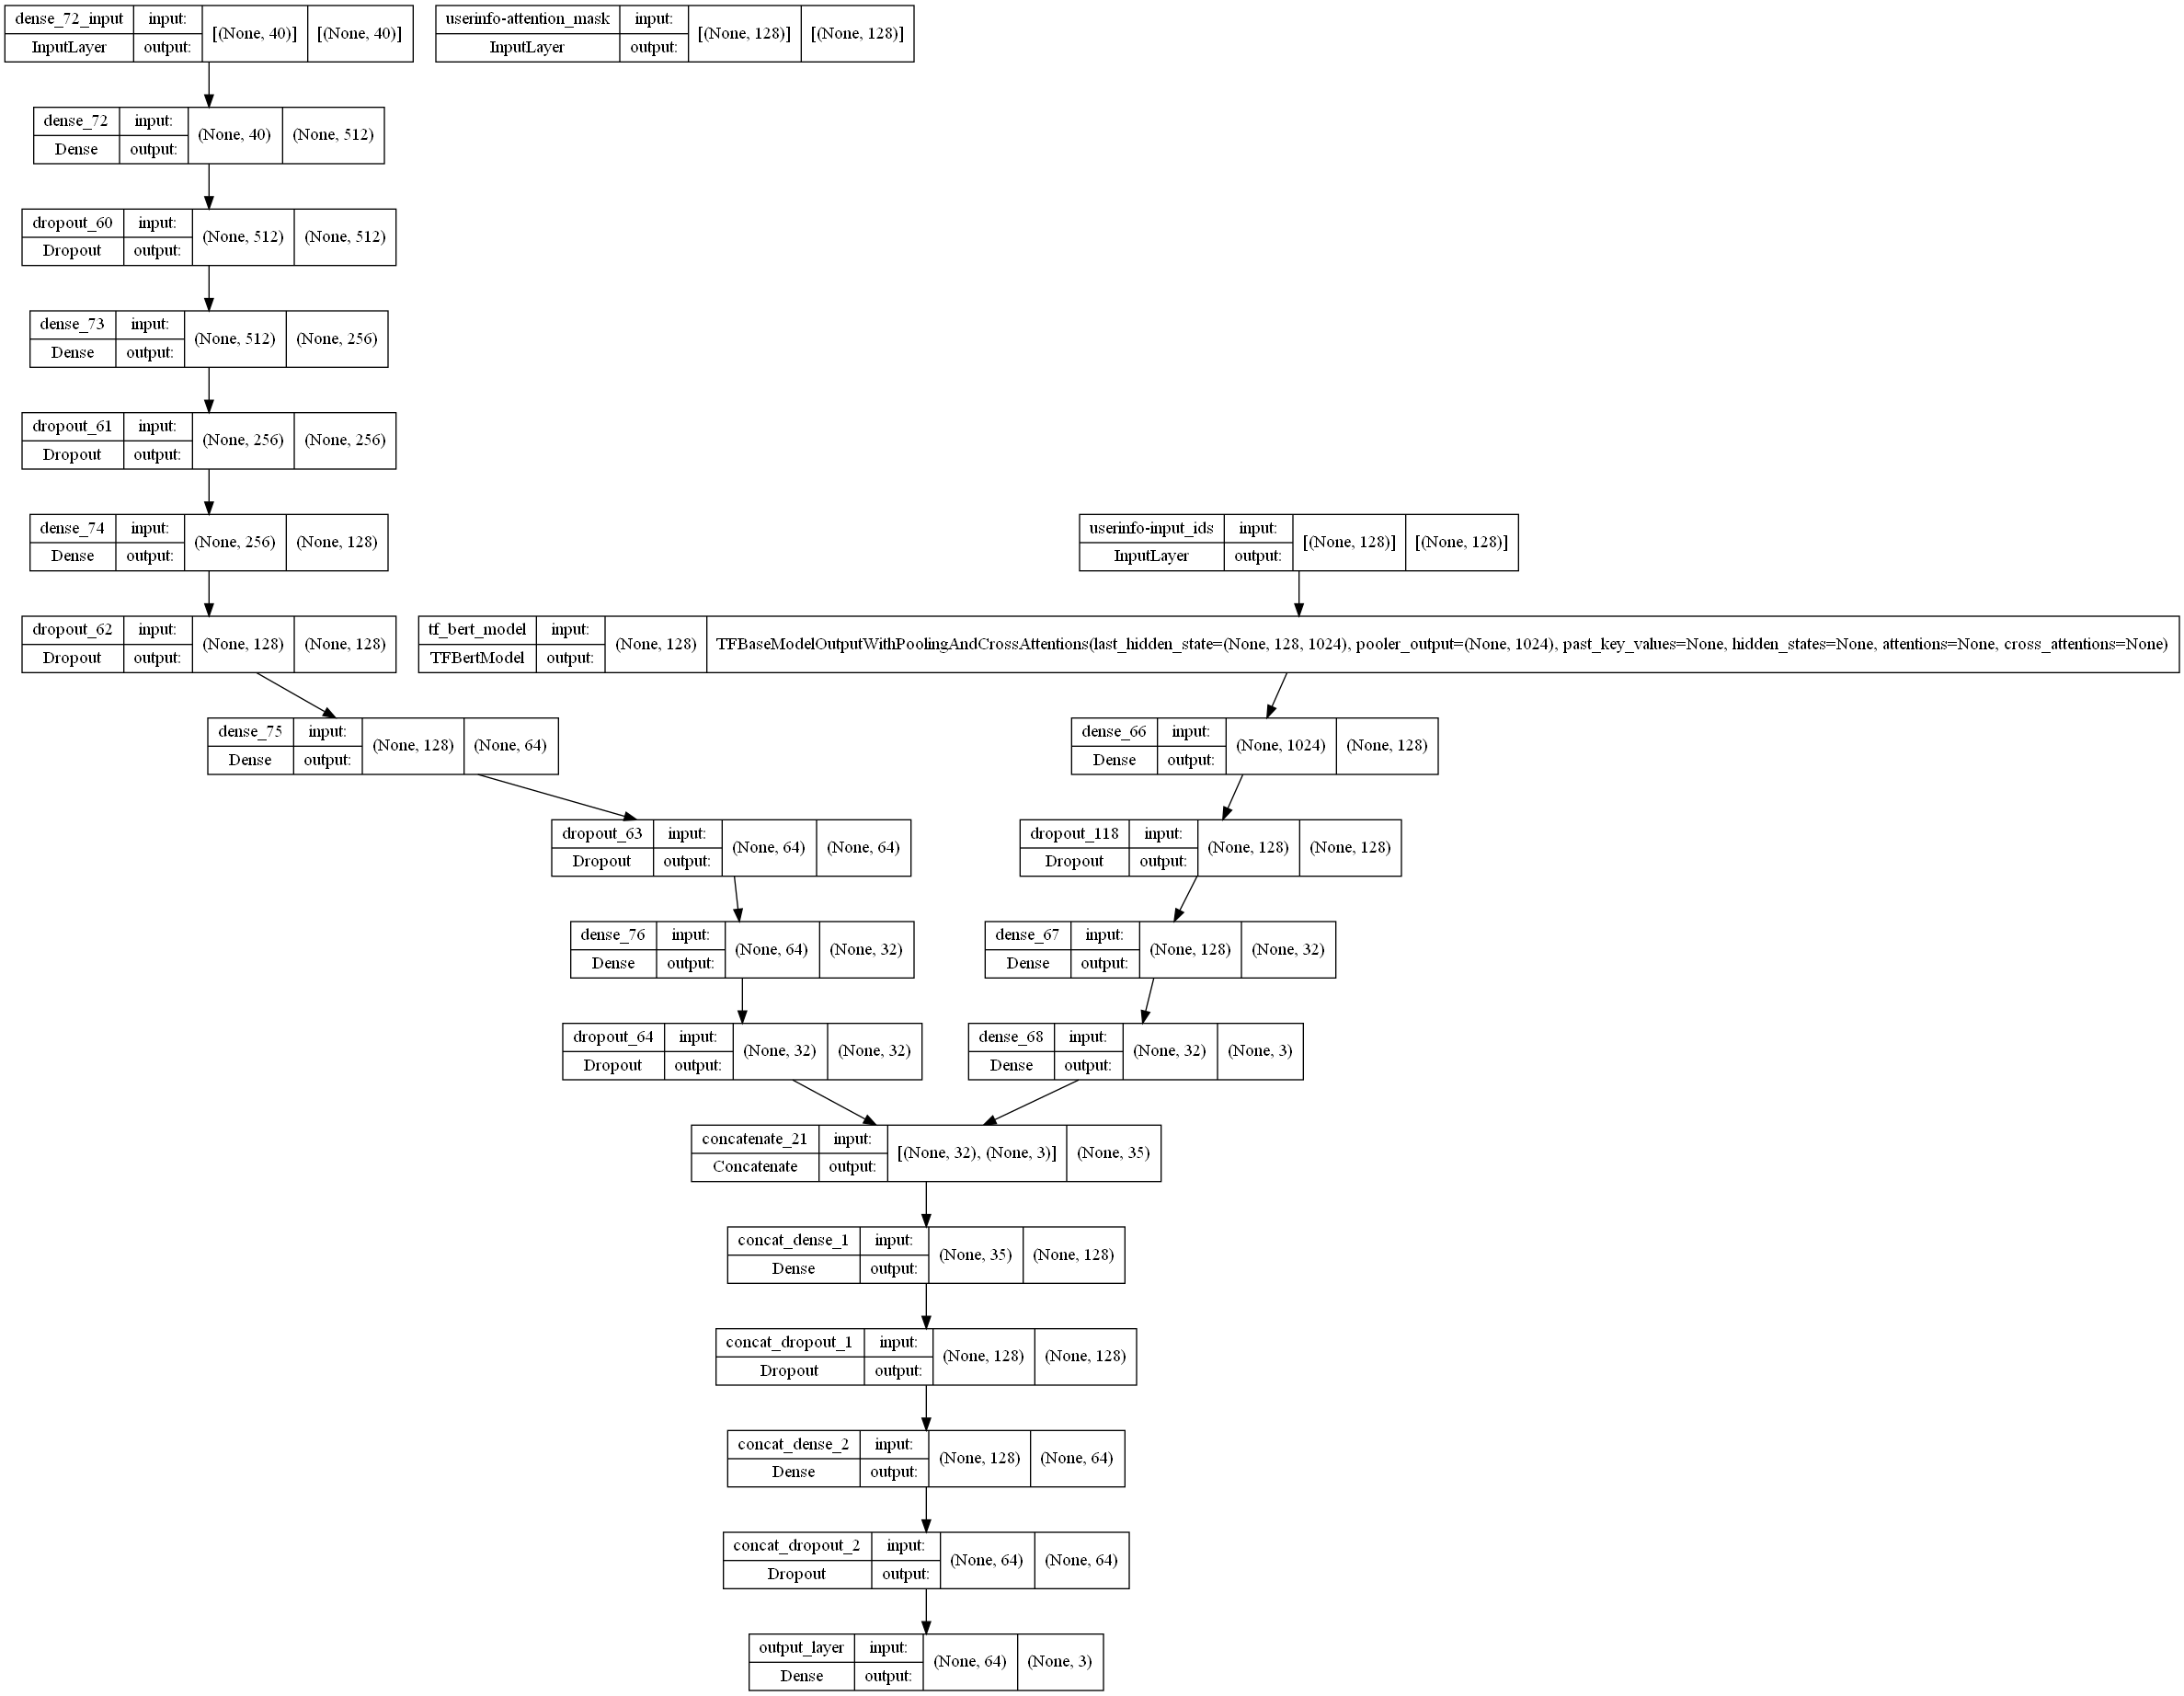

In [251]:
metadata_and_user_info = concat_network([nn_model, bert_user_info])

plot_model(metadata_and_user_info, show_shapes=True)

#### Train the new network

In [252]:
metadata_and_user_info_results = train(
  network = metadata_and_user_info,
  x_train_input = [x_train_meta_data, bert_train_user_text_input],
  x_test_input = [x_test_meta_data, bert_test_user_text_input],
  name = 'Metadata and user info'
)

Epoch 1/8
40/40 [==============================] - 130s 3s/step - loss: 1.7239 - accuracy: 0.6661 - val_loss: 0.5122 - val_accuracy: 0.7674
Epoch 2/8
40/40 [==============================] - 101s 3s/step - loss: 0.6991 - accuracy: 0.7548 - val_loss: 0.4939 - val_accuracy: 0.7842
Epoch 3/8
40/40 [==============================] - 100s 3s/step - loss: 0.6479 - accuracy: 0.7518 - val_loss: 0.4957 - val_accuracy: 0.7954
Epoch 4/8
40/40 [==============================] - 100s 3s/step - loss: 0.6354 - accuracy: 0.7514 - val_loss: 0.4953 - val_accuracy: 0.7994
Epoch 5/8
40/40 [==============================] - 100s 3s/step - loss: 0.5789 - accuracy: 0.7646 - val_loss: 0.4991 - val_accuracy: 0.7930
Epoch 6/8
40/40 [==============================] - 101s 3s/step - loss: 0.5874 - accuracy: 0.7584 - val_loss: 0.5056 - val_accuracy: 0.7954
Epoch 7/8
40/40 [==============================] - 100s 3s/step - loss: 0.5831 - accuracy: 0.7638 - val_loss: 0.5108 - val_accuracy: 0.7978
Epoch 8/8
40/40 [===

#### Display the results

Metadata and user info classification report:
              precision    recall  f1-score   support

           0       0.68      0.90      0.77       434
           1       0.58      0.19      0.29       192
           2       0.87      0.86      0.87       938

    accuracy                           0.79      1564
   macro avg       0.71      0.65      0.64      1564
weighted avg       0.78      0.79      0.77      1564



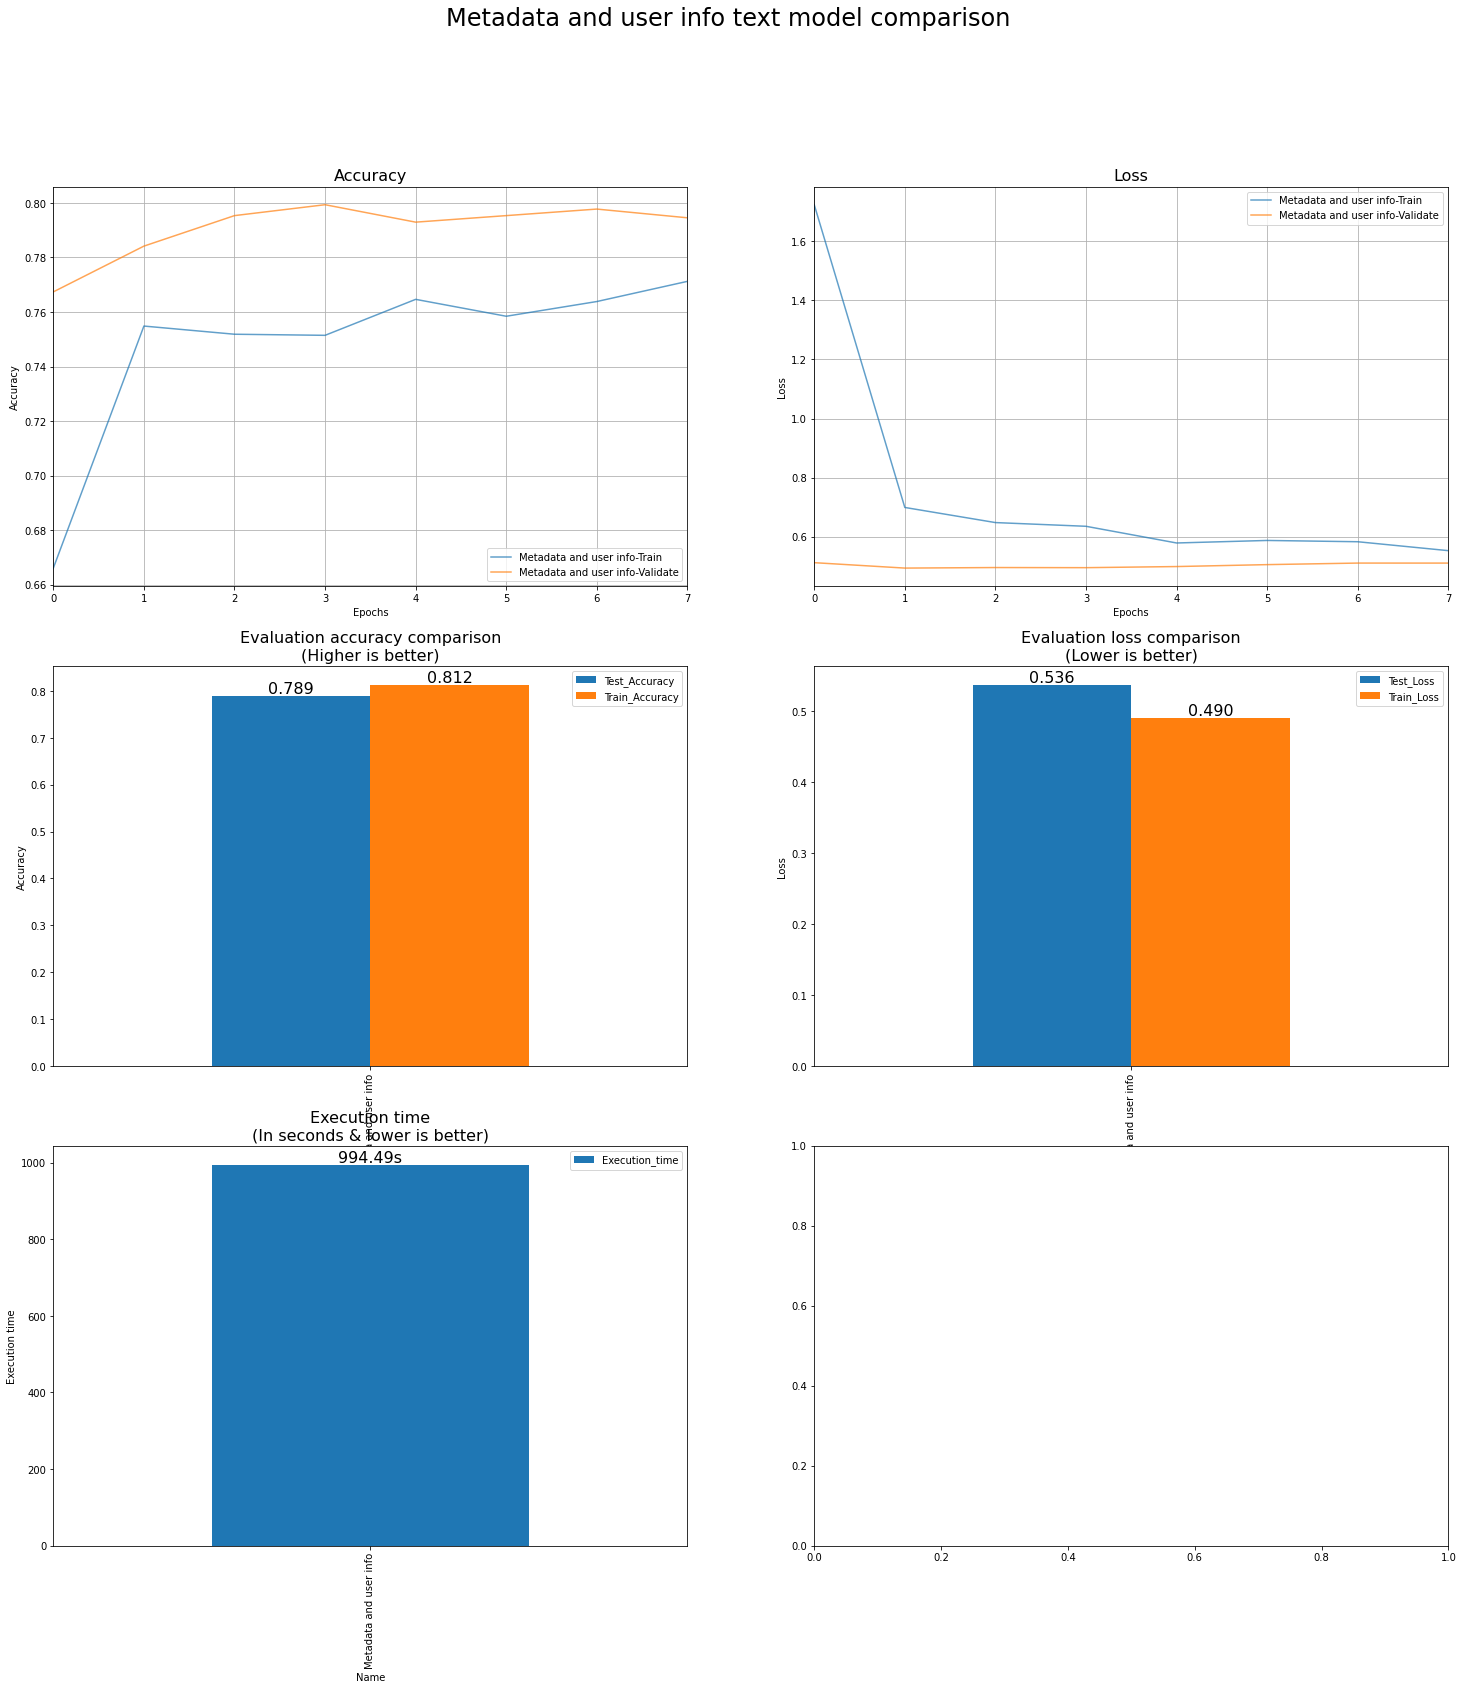

In [253]:
plot_results('Metadata and user info text', [metadata_and_user_info_results], True)

### Metadata + tweet concat

#### Load the pre-trained bert tweet model

In [254]:
bert_tweet = get_model()

bert_tweet.load_weights('./text/bert-tweet2022-weights.h5')

# the model is already trained so we set layers to non trainable
for layer in bert_tweet.layers:
  layer.trainable = False

  if isinstance(layer, keras.engine.input_layer.InputLayer):
    layer._name = "tweet-" + layer._name

bert_tweet.summary()

# the last layer is the output layer (softmax), we don't need that one for the concatenate, so we need the second to last layer
bert_tweet.layers.pop()

Model: "model_45"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 tweet-input_ids (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 tweet-attention_mask (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  335141888   ['tweet-input_ids[0][0]',        
                                thPoolingAndCrossAt               'tweet-attention_mask[0][0]']   
                                tentions(last_hidde                                        

#### Create the concatenated network

Model: "model_46"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 dense_72_input (InputLayer)    [(None, 40)]         0           []                               
                                                                                                  
 dense_72 (Dense)               (None, 512)          20992       ['dense_72_input[0][0]']         
                                                                                                  
 dropout_60 (Dropout)           (None, 512)          0           ['dense_72[0][0]']               
                                                                                                  
 dense_73 (Dense)               (None, 256)          131328      ['dropout_60[0][0]']             
                                                                                           

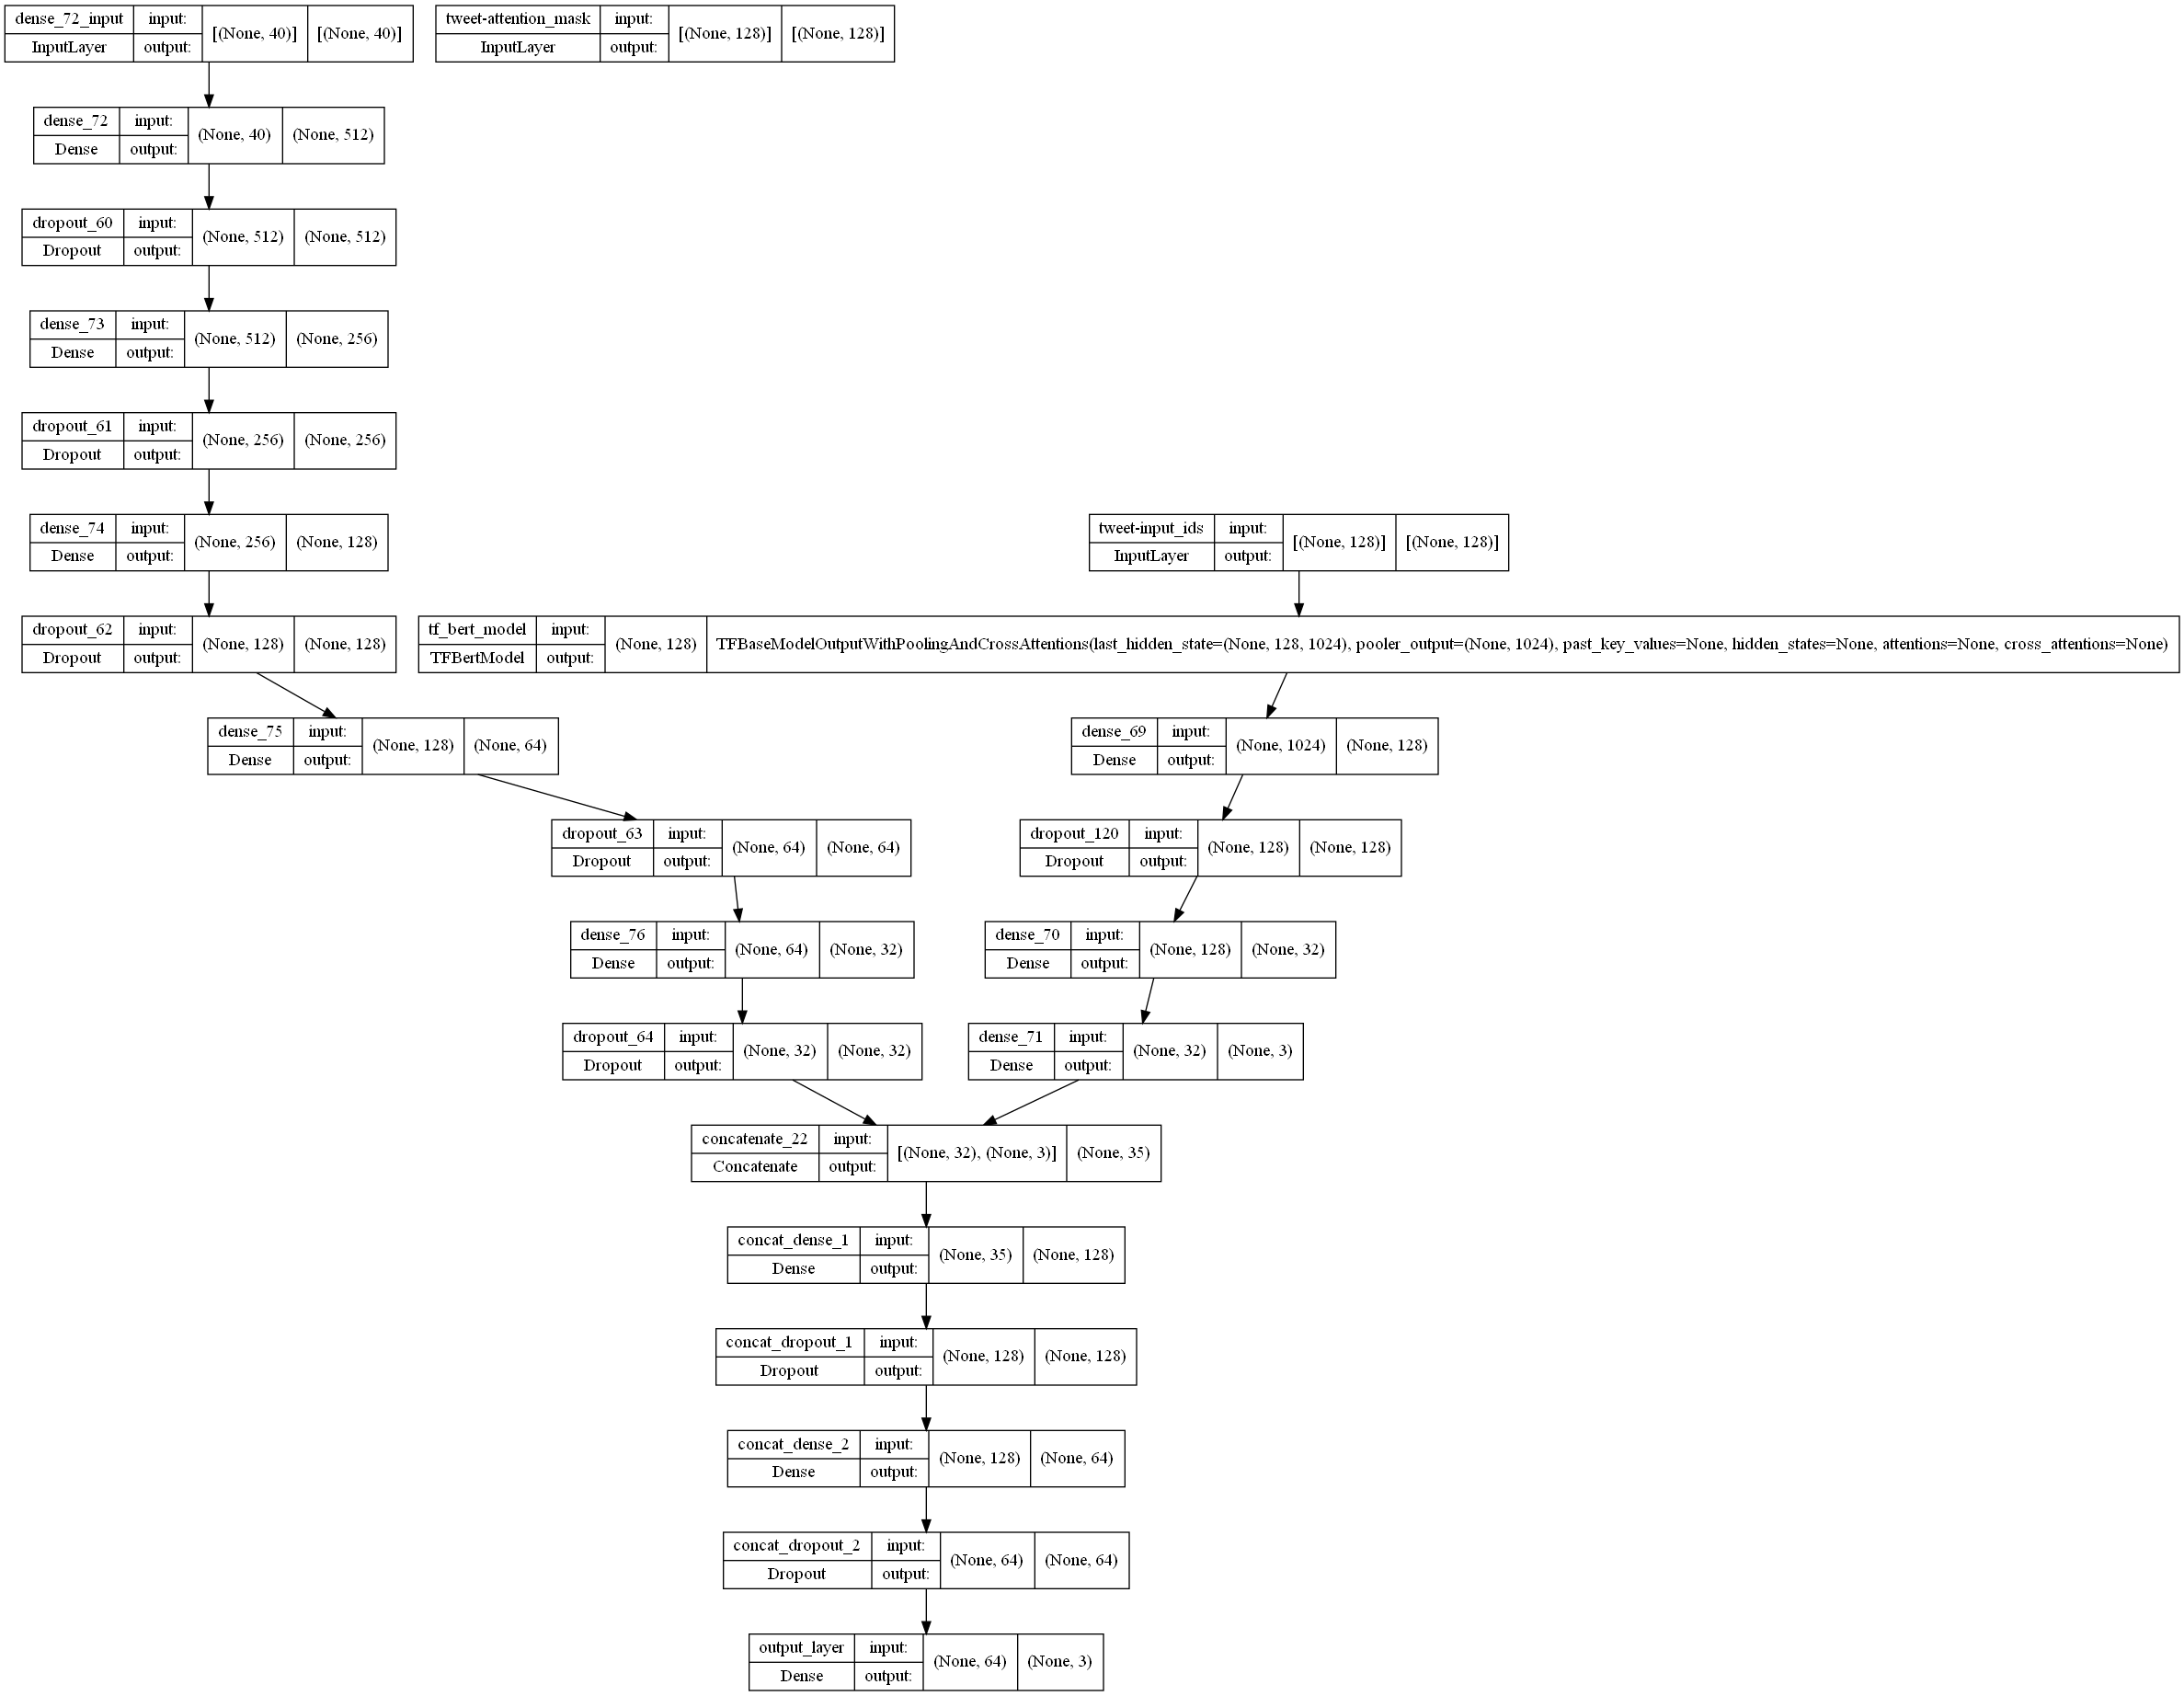

In [255]:
metadata_tweet = concat_network([nn_model, bert_tweet])

plot_model(metadata_tweet, show_shapes=True)

#### Train the network

In [256]:
metadata_tweet_results = train(
  network = metadata_tweet,
  x_train_input = [x_train_meta_data, bert_train_tweet_input],
  x_test_input = [x_test_meta_data, bert_test_tweet_input],
  name = 'Metadata and tweet'
)

Epoch 1/8
40/40 [==============================] - 128s 3s/step - loss: 1.5506 - accuracy: 0.6719 - val_loss: 0.4922 - val_accuracy: 0.7842
Epoch 2/8
40/40 [==============================] - 101s 3s/step - loss: 0.7290 - accuracy: 0.7485 - val_loss: 0.4917 - val_accuracy: 0.7962
Epoch 3/8
40/40 [==============================] - 101s 3s/step - loss: 0.6850 - accuracy: 0.7451 - val_loss: 0.5008 - val_accuracy: 0.7874
Epoch 4/8
40/40 [==============================] - 101s 3s/step - loss: 0.6449 - accuracy: 0.7566 - val_loss: 0.5074 - val_accuracy: 0.7866
Epoch 5/8
40/40 [==============================] - 101s 3s/step - loss: 0.6081 - accuracy: 0.7560 - val_loss: 0.5168 - val_accuracy: 0.7746
Epoch 6/8
40/40 [==============================] - 101s 3s/step - loss: 0.6043 - accuracy: 0.7534 - val_loss: 0.5194 - val_accuracy: 0.7674
Epoch 7/8
40/40 [==============================] - 101s 3s/step - loss: 0.5768 - accuracy: 0.7508 - val_loss: 0.5213 - val_accuracy: 0.7754
Epoch 8/8
40/40 [===

#### Plot the results

Metadata and tweet classification report:
              precision    recall  f1-score   support

           0       0.68      0.89      0.77       434
           1       0.00      0.00      0.00       192
           2       0.82      0.87      0.85       938

    accuracy                           0.77      1564
   macro avg       0.50      0.59      0.54      1564
weighted avg       0.68      0.77      0.72      1564



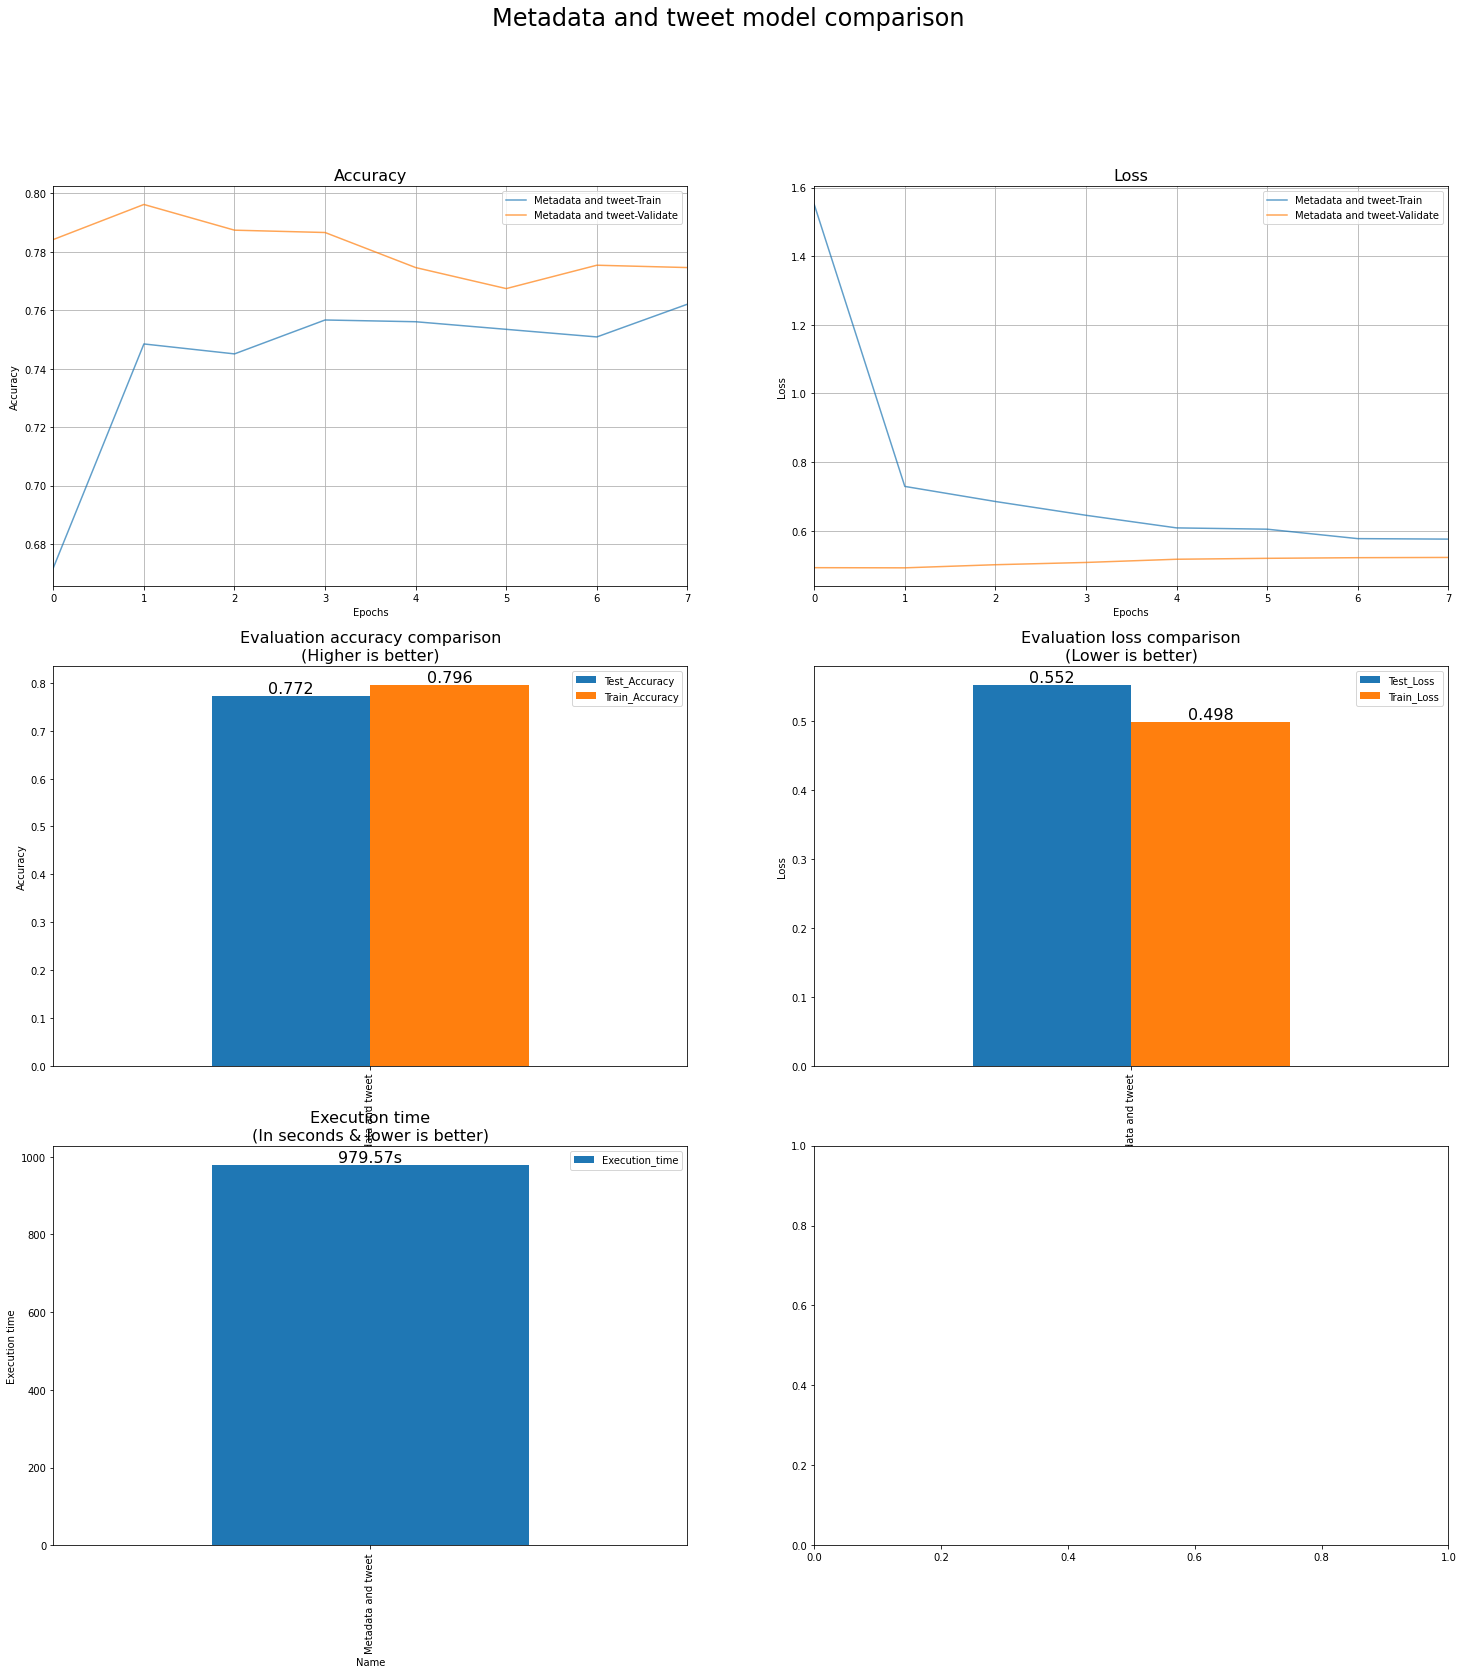

In [257]:
plot_results('Metadata and tweet', [metadata_tweet_results], True)

### Metadata + userinfo + tweet concat

#### Create the concatenated network

Model: "model_47"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 dense_72_input (InputLayer)    [(None, 40)]         0           []                               
                                                                                                  
 dense_72 (Dense)               (None, 512)          20992       ['dense_72_input[0][0]']         
                                                                                                  
 dropout_60 (Dropout)           (None, 512)          0           ['dense_72[0][0]']               
                                                                                                  
 dense_73 (Dense)               (None, 256)          131328      ['dropout_60[0][0]']             
                                                                                           

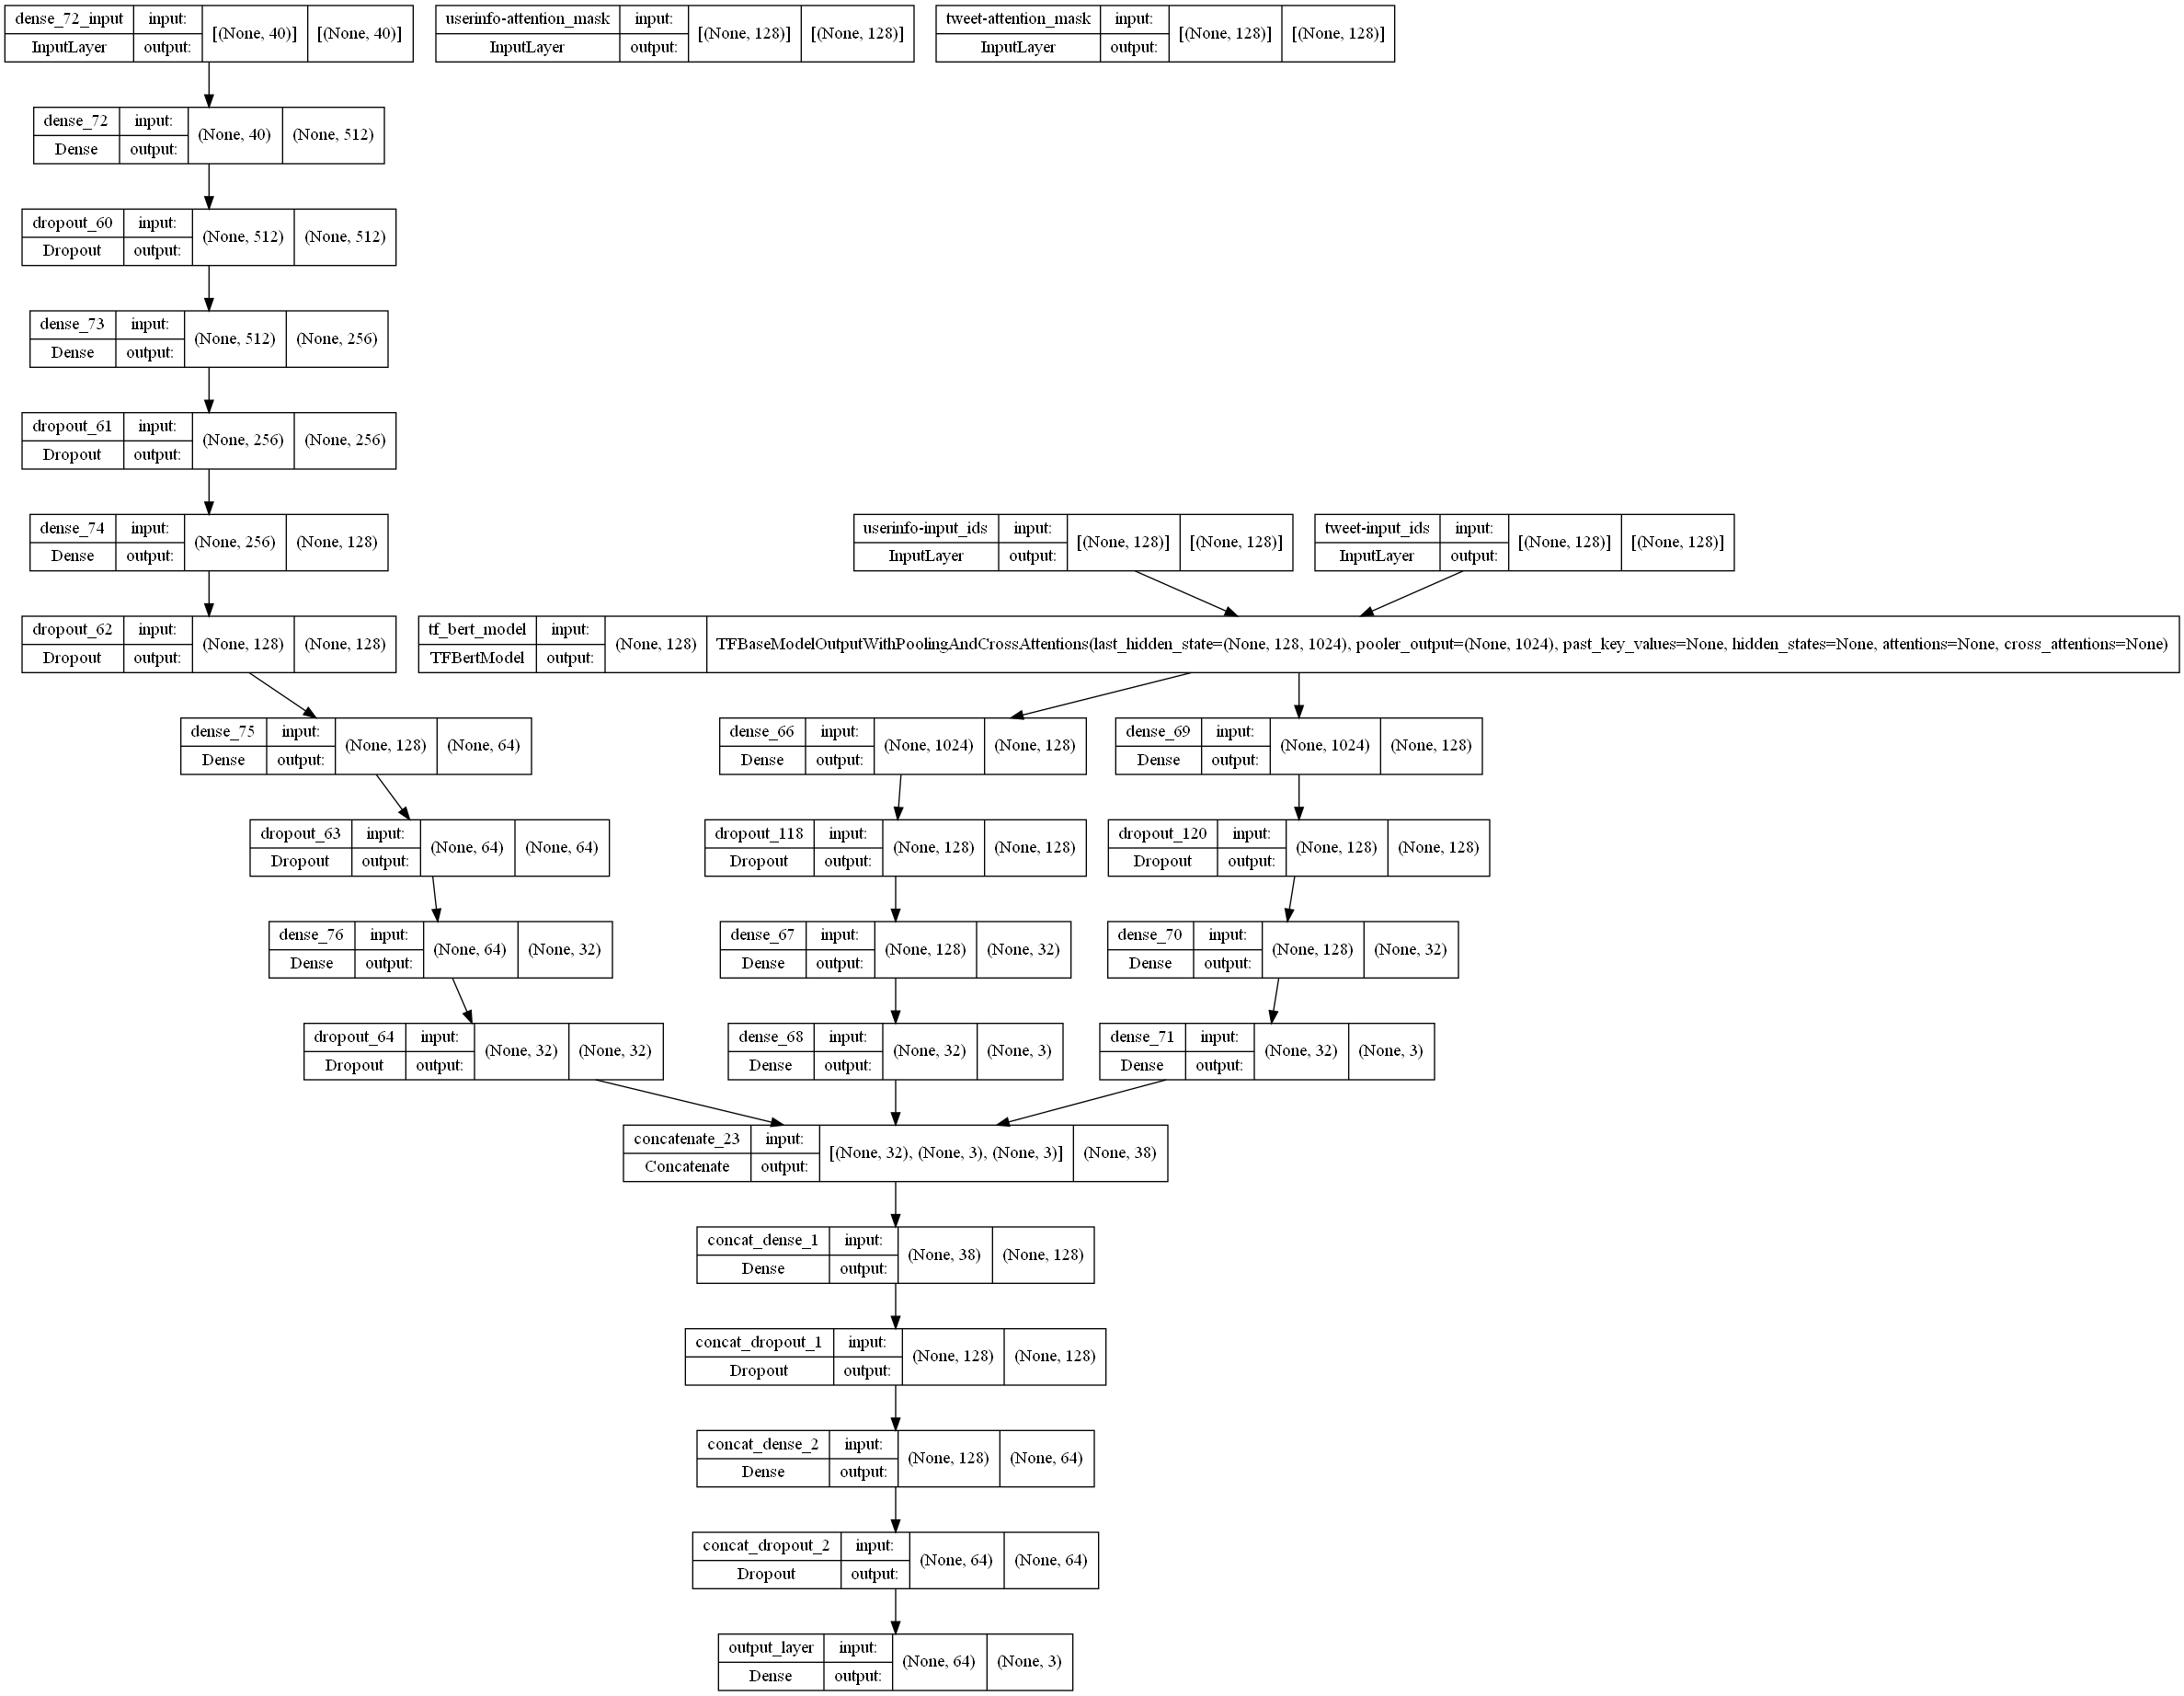

In [258]:
metadata_user_info_tweet = concat_network([nn_model, bert_user_info, bert_tweet])

plot_model(metadata_user_info_tweet, show_shapes=True)

#### Train the network

In [259]:
metadata_user_info_tweet_results = train(
  network = metadata_user_info_tweet,
  x_train_input = [x_train_meta_data, bert_train_user_text_input, bert_train_tweet_input],
  x_test_input = [x_test_meta_data, bert_test_user_text_input, bert_test_tweet_input],
  name = 'Metadata user info and tweet'
)

Epoch 1/8
40/40 [==============================] - 245s 5s/step - loss: 0.9811 - accuracy: 0.6997 - val_loss: 0.4981 - val_accuracy: 0.7794
Epoch 2/8
40/40 [==============================] - 196s 5s/step - loss: 0.6779 - accuracy: 0.7461 - val_loss: 0.5027 - val_accuracy: 0.7930
Epoch 3/8
40/40 [==============================] - 197s 5s/step - loss: 0.6278 - accuracy: 0.7508 - val_loss: 0.5040 - val_accuracy: 0.7914
Epoch 4/8
40/40 [==============================] - 196s 5s/step - loss: 0.5885 - accuracy: 0.7580 - val_loss: 0.5109 - val_accuracy: 0.7930
Epoch 5/8
40/40 [==============================] - 194s 5s/step - loss: 0.5735 - accuracy: 0.7640 - val_loss: 0.5091 - val_accuracy: 0.7930
Epoch 6/8
40/40 [==============================] - 183s 5s/step - loss: 0.5811 - accuracy: 0.7564 - val_loss: 0.5190 - val_accuracy: 0.7858
Epoch 7/8
40/40 [==============================] - 202s 5s/step - loss: 0.5807 - accuracy: 0.7682 - val_loss: 0.5247 - val_accuracy: 0.7818
Epoch 8/8
40/40 [===

#### Plot the results

Metadata user info and tweet classification report:
              precision    recall  f1-score   support

           0       0.69      0.89      0.78       434
           1       0.00      0.00      0.00       192
           2       0.82      0.88      0.85       938

    accuracy                           0.78      1564
   macro avg       0.51      0.59      0.54      1564
weighted avg       0.69      0.78      0.73      1564



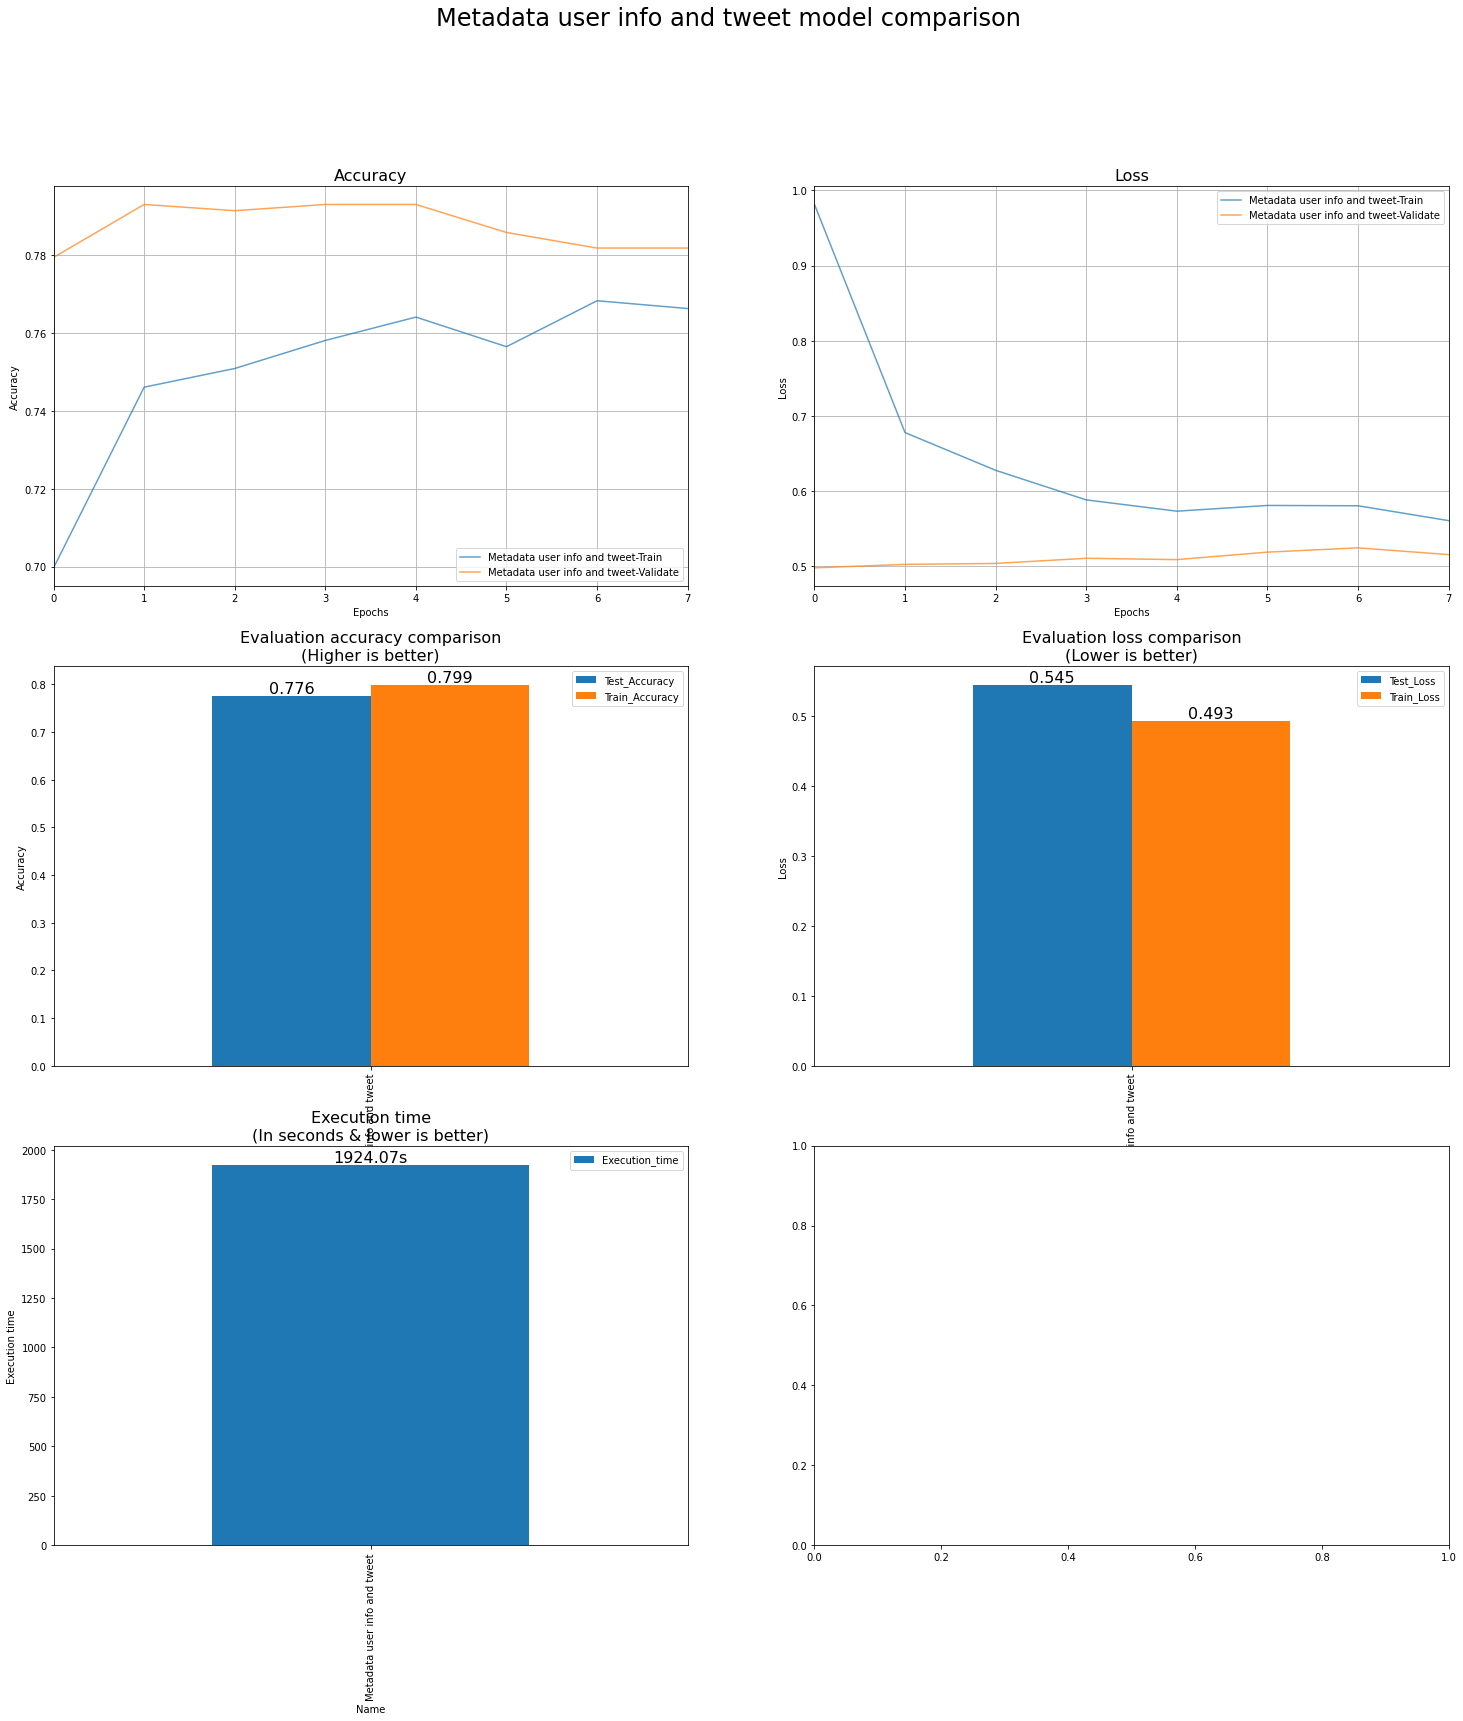

In [260]:
plot_results('Metadata user info and tweet', [metadata_user_info_tweet_results], True)

## Comparison

Metadata and user info classification report:
              precision    recall  f1-score   support

           0       0.68      0.90      0.77       434
           1       0.58      0.19      0.29       192
           2       0.87      0.86      0.87       938

    accuracy                           0.79      1564
   macro avg       0.71      0.65      0.64      1564
weighted avg       0.78      0.79      0.77      1564

Metadata user info and tweet classification report:
              precision    recall  f1-score   support

           0       0.69      0.89      0.78       434
           1       0.00      0.00      0.00       192
           2       0.82      0.88      0.85       938

    accuracy                           0.78      1564
   macro avg       0.51      0.59      0.54      1564
weighted avg       0.69      0.78      0.73      1564

Metadata and tweet classification report:
              precision    recall  f1-score   support

           0       0.68      0.89      0.77

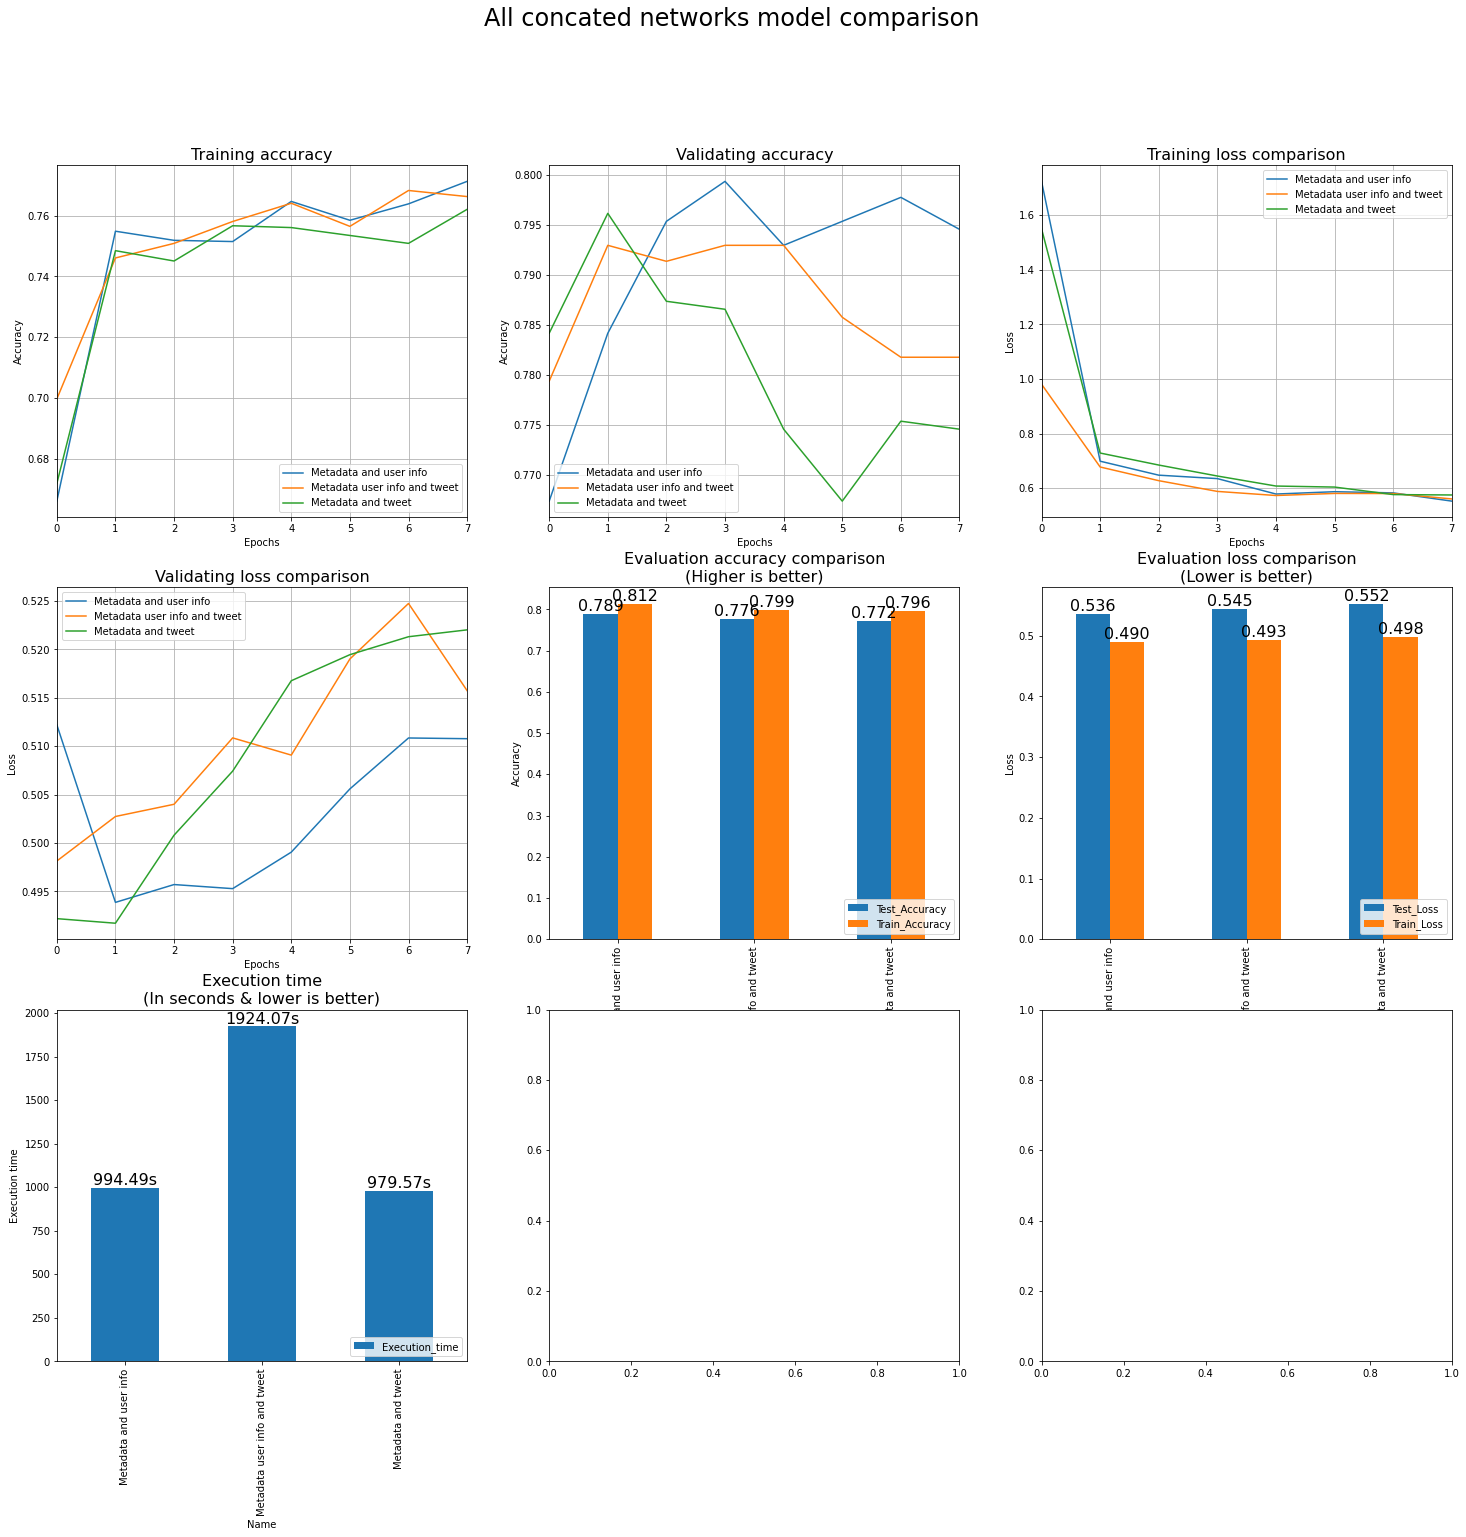

In [263]:
plot_results('All concated networks', [metadata_and_user_info_results, metadata_tweet_results, metadata_user_info_tweet_results], False)